In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kagglejson/kaggle.json
/kaggle/input/mlframework/LICENSE
/kaggle/input/mlframework/.gitignore
/kaggle/input/mlframework/README.md
/kaggle/input/mlframework/requirements.txt
/kaggle/input/mlframework/setup.py
/kaggle/input/mlframework/cnn/models.json
/kaggle/input/mlframework/cnn/model_builder.py
/kaggle/input/mlframework/cnn/__init__.py
/kaggle/input/mlframework/utils/metrics.py
/kaggle/input/mlframework/utils/file_utils.py
/kaggle/input/mlframework/utils/misc.py
/kaggle/input/mlframework/utils/charts.py
/kaggle/input/mlframework/utils/cross_validation.py
/kaggle/input/mlframework/utils/__init__.py
/kaggle/input/mlframework/mllib/dispatcher.py
/kaggle/input/mlframework/mllib/model_builder.py
/kaggle/input/mlframework/mllib/clf_models.json
/kaggle/input/mlframework/mllib/ml.py
/kaggle/input/mlframework/mllib/__init__.py
/kaggle/input/mlframework/preprocessing/image.py
/kaggle/input/mlframework/preprocessing/features.py
/kaggle/input/mlframework/preprocessing/__init__.py
/k

### Install modules

In [2]:
! pip install livelossplot

In [3]:
! ls -ltar /kaggle/input/planet-understanding-the-amazon-from-space

total 2596
drwxr-xr-x 2 nobody nogroup       0 Jul 14 09:33 test_v2_file_mapping.csv
drwxr-xr-x 2 nobody nogroup       0 Jul 14 09:33 sample_submission_v2.csv
-rw-r--r-- 1 nobody nogroup 1594569 Jul 14 09:33 Kaggle-planet-test-tif.torrent
drwxr-xr-x 5 nobody nogroup       0 Jul 14 09:33 .
-rw-r--r-- 1 nobody nogroup 1055292 Jul 14 09:33 Kaggle-planet-train-tif.torrent
drwxr-xr-x 2 nobody nogroup       0 Jul 14 09:33 train_v2.csv
drwxr-xr-x 5 root   root       4096 Aug  4 18:11 ..



### Import the libraries

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow.keras as keras

import sys
sys.path.append('/kaggle/input/mlframework')

# import mlframework as xmf


##### Create directory for data and weights

In [5]:
INPUT_DIR = '/kaggle/input'
OUTPUT_DIR = '/kaggle/working'

# directory to keep weights
WEIGHTS_DIR = os.path.join(OUTPUT_DIR, 'weights')
if not os.path.isdir(WEIGHTS_DIR):
    os.mkdir(WEIGHTS_DIR)
    
# directory to keep data files
DATA_DIR = os.path.join(OUTPUT_DIR, 'data')
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

### Extract the data from tar file
Need to configure the kaggle first, copy the credentials to ~/.kaggle folder

In [6]:
# Create directory to place API key file
if not os.path.isdir(os.path.join(os.path.expanduser('~'), '.kaggle')):
    os.mkdir(os.path.join(os.path.expanduser('~'), '.kaggle'))
    
# Download the kaggle dataset
!cp /kaggle/input/kagglejson/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download nikitarom/planets-dataset -p '/kaggle/working/data'

 98%|█████████████████████████████████████▎| 1.47G/1.50G [00:49<00:01, 22.1MB/s]
100%|██████████████████████████████████████| 1.50G/1.50G [00:49<00:00, 32.2MB/s]


#### Unzip the files

In [7]:
# from utils.file_utils import unzip_file
# unzip_file(os.path.join(DATA_DIR, 'planets-dataset.zip'), DATA_DIR)

!unzip -q -n '/kaggle/working/data/planets-dataset.zip' -d '/kaggle/working/data'

In [8]:
DATA_DIR = os.path.join(OUTPUT_DIR, 'data', 'planet', 'planet') # chagne to the extracted folder
TRAIN_DIR = os.path.join(DATA_DIR, 'train-jpg')
TEST_DIR  = os.path.join(DATA_DIR, 'test-jpg')

### Load data into pandas

Number of training images : 40479
Number of test images : 40669


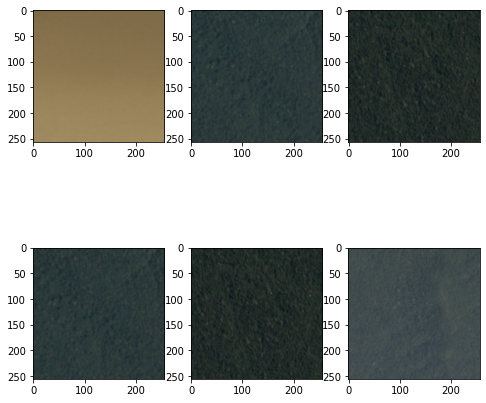

In [9]:
train_files = os.listdir(TRAIN_DIR)
test_files = os.listdir(TEST_DIR)

print(f'Number of training images : {len(train_files)}\nNumber of test images : {len(test_files)}')

import random
from utils.charts import plot_images

images = random.sample(train_files, 9)
images = [os.path.join(TRAIN_DIR, image) for image in images]
plot_images(images, row=2, col=3)

##### Create the tags dictionary

In [10]:
train_df = pd.read_csv(os.path.join(DATA_DIR,'train_classes.csv'))
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [11]:
test_df = pd.DataFrame(test_files, columns=['image_name'])
test_df.head() 

,image_name
0,test_12753.jpg
1,test_11519.jpg
2,test_7128.jpg
3,test_8813.jpg
4,test_24814.jpg


In [12]:
# Create a dictionary for the tags
tags = train_df['tags'].str.split(' ').explode().unique().tolist()
print(f'Total number of tags : {len(tags)}')

# create a dictionary for the tags
tags_dict = dict()
for i, tag in enumerate(tags):
    tags_dict[i] = tag

tags_dict

Total number of tags : 17


{0: 'haze',
 1: 'primary',
 2: 'agriculture',
 3: 'clear',
 4: 'water',
 5: 'habitation',
 6: 'road',
 7: 'cultivation',
 8: 'slash_burn',
 9: 'cloudy',
 10: 'partly_cloudy',
 11: 'conventional_mine',
 12: 'bare_ground',
 13: 'artisinal_mine',
 14: 'blooming',
 15: 'selective_logging',
 16: 'blow_down'}

In [13]:
# Convert the tags from list to One-hot encoder array
tags = train_df['tags'].str.split(' ')
from sklearn.preprocessing import MultiLabelBinarizer
lb = MultiLabelBinarizer()
encoded = lb.fit_transform(tags)
encoded

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [14]:
one_hot_df = pd.DataFrame(encoded, columns=lb.classes_, dtype=int, index=train_df.index)
df = pd.concat([train_df, one_hot_df], axis=1)
df['image_name'] = df['image_name'].apply(lambda x: f'{x}.jpg')

from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size=0.1, shuffle=True)
len(train_df), len(valid_df)

y_cols = df.columns.tolist()[2:]
y_cols

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [15]:
df.head()

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1.jpg,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


#### Loss function
Define the loss function

In [16]:
from keras import backend
def f2_score(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

##### Define the Generators and callbacks in the method to train model

In [24]:
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from livelossplot.inputs.keras import PlotLossesCallback
from keras.optimizers import Adam
from sklearn.metrics import fbeta_score

INPUT_SHAPE = (128, 128, 3)

# Method to train the passed model
def train_model(input_df, model, x_col, y_col, weight_prefix,
                preprocess_input=None,
                batch_size=32, epochs=25, verbose=0):
    
    train_result_df = []
    # Take a 5 fold cross validation 
    cv = KFold(n_splits=5, shuffle=True, random_state=1024)
    fold = 1
    # Define the callbacks
    es = EarlyStopping(monitor="val_fbeta_score", patience=4)
    # compile model 
    lr = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)
    plot_loss = PlotLossesCallback()
    
    # set model weight and path
    weight_filename = f'{weight_prefix}_weight_best_fold_{fold}'
    weight_filepath = os.path.join(WEIGHTS_DIR, weight_filename)
    print(f'Fold : {fold}, Model Weight : {weight_filepath}')
    ckpt= ModelCheckpoint(
        filepath=weight_filepath,
        save_weights_only=True,
        monitor="val_fbeta_score",
        mode="auto",
        save_best_only=True,
        )
        
    model.compile(optimizer=Adam(),loss='binary_crossentropy', metrics=[f2_score])
    
    # Loop for each fold 
    for train_index, val_index in cv.split(input_df[x_col]):
        train_df, valid_df = df.iloc[train_index], df.iloc[val_index]
        # Generators
        train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True,
                                           vertical_flip=True)
        #         valid_datagen = ImageDataGenerator(rescale=1.0/255)
        
        train_gen = train_datagen.flow_from_dataframe(train_df, directory=TRAIN_DIR,
                                                      x_col=x_col, y_col=y_col,
                                                      batch_size=batch_size, class_mode='raw',
                                                      target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
                                                      preprocessing_function=preprocess_input)

        valid_gen = train_datagen.flow_from_dataframe(valid_df, directory=TRAIN_DIR,
                                                      x_col=x_col, y_col=y_col,
                                                      batch_size=batch_size, class_mode='raw',
                                                      target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
                                                      preprocessing_function=preprocess_input)

        # start training
        history = model.fit(train_gen, validation_data=valid_gen,
                            epochs=epochs, callbacks=[es, ckpt, lr, plot_loss],
                            verbose=verbose)
        result_df = pd.DataFrame(history.history)
        result_df['fold'] = fold
        train_result_df.append(result_df)
        fold += 1
    
    model.save(os.path.join(WEIGHTS_DIR, f'{weight_prefix}_weight_best'))        
    return pd.concat(train_result_df)


# Method to train the passed model
def train_model_v2(input_df, model, x_col, y_col, weight_prefix,
                preprocess_input=None,
                batch_size=32, epochs=25, verbose=0):
    
    from sklearn.model_selection import train_test_split
    import time

    # Split dataset 
    df_train, df_valid = train_test_split(input_df, test_size=0.2, shuffle=True)
    
    # Generators
    train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True,
                                       vertical_flip=True)
    
    train_gen = train_datagen.flow_from_dataframe(df_train, directory=TRAIN_DIR,
                                                  x_col=x_col, y_col=y_col,
                                                  batch_size=batch_size, class_mode='raw',
                                                  target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
                                                  preprocessing_function=preprocess_input)

    valid_gen = train_datagen.flow_from_dataframe(df_valid, directory=TRAIN_DIR,
                                                  x_col=x_col, y_col=y_col,
                                                  batch_size=batch_size, class_mode='raw',
                                                  target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
                                                  preprocessing_function=preprocess_input)
    
    # compile model 
    model.compile(optimizer=Adam(),loss='binary_crossentropy', metrics=[f2_score])

    # Define the callbacks
    es = EarlyStopping(monitor="val_f2_score", patience=4)
    
    # set model weight and path
    weight_filename = f'{weight_prefix}_weight_best.hdf5'
    weight_filepath = os.path.join(WEIGHTS_DIR, weight_filename)
    print(f'Model Weight file : {weight_filepath}')
    ckpt= ModelCheckpoint(
        filepath=weight_filepath,
        save_weights_only=True,
        monitor="val_f2_score",
        mode="auto",
        save_best_only=True,
    )
    lr = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1)
    plot_loss = PlotLossesCallback()     
    
    # start training

    start_time = time.perf_counter()
    history = model.fit(train_gen, validation_data=valid_gen,
                        epochs=epochs, callbacks=[es, ckpt, lr, plot_loss],
                        verbose=verbose)
    end_time = time.perf_counter()
    result_df = pd.DataFrame(history.history)
    print(f'Time taken : {time.strftime("%H:%M:%S", time.gmtime(end_time-start_time))}')
    return result_df


In [18]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.models import Model, Sequential

### Create base model from scratch

In [ ]:
from cnn.model_builder import get_vgg_block

base_cnn = get_vgg_block(3, input_shape=INPUT_SHAPE)

model = base_cnn
model.add(Flatten())
model.add(Dense(17, activation='sigmoid'))
model.summary()

result_df = train_model(df, model, x_col='image_name', y_col=y_cols,
                        weight_prefix='vgg_block', batch_size=32, epochs=5, verbose=1)
result_df

In [ ]:
from cnn.model_builder import get_vgg_block

base_cnn = get_vgg_block(3, input_shape=INPUT_SHAPE)

model_v2 = base_cnn
model_v2.add(Flatten())
model_v2.add(Dense(17, activation='sigmoid'))
# model_v2.summary()

result_df = train_model_v2(df, model_v2, x_col='image_name', y_col=y_cols,
                        weight_prefix='vgg_block_v2', batch_size=32, epochs=15, verbose=1)
result_df

### Create Model from Transfer Learning

#### VGG19

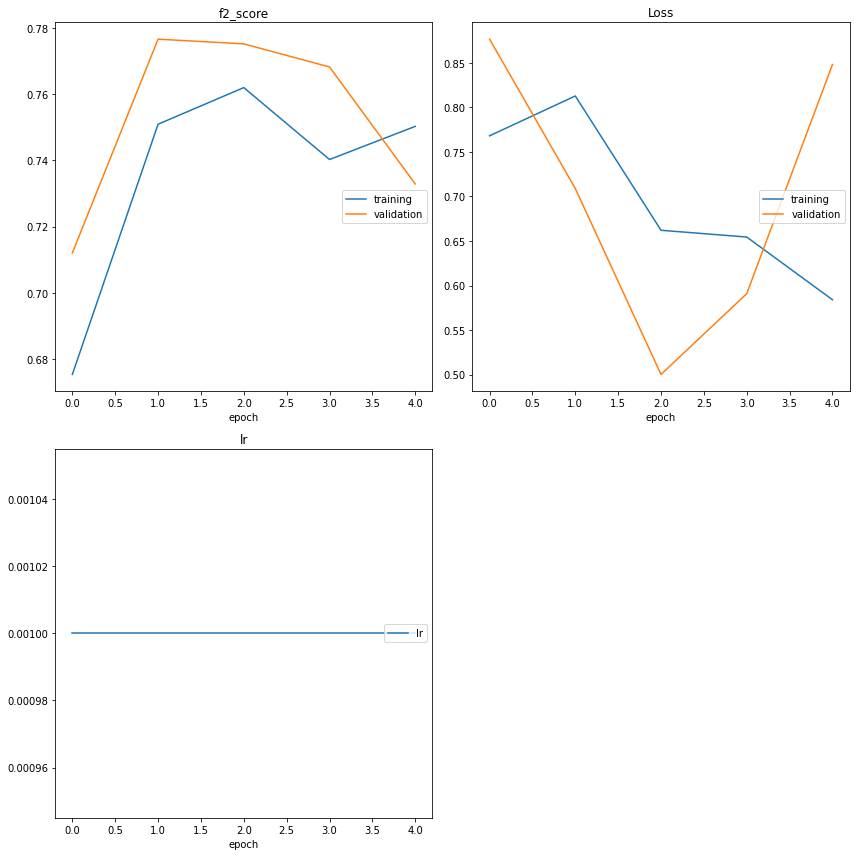

f2_score
	training         	 (min:    0.675, max:    0.762, cur:    0.750)
	validation       	 (min:    0.712, max:    0.777, cur:    0.733)
Loss
	training         	 (min:    0.584, max:    0.813, cur:    0.584)
	validation       	 (min:    0.500, max:    0.876, cur:    0.848)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
Time taken : 00:07:15


,loss,f2_score,val_loss,val_f2_score,lr
0,0.767972,0.675308,0.876447,0.712018,0.001
1,0.812705,0.750905,0.708860,0.776598,0.001
2,0.661983,0.761962,0.500202,0.775179,0.001
3,0.654395,0.740241,0.590851,0.768197,0.001
4,0.584035,0.750248,0.847989,0.732855,0.001


In [37]:
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

vgg_model = VGG19(include_top=False, input_shape=INPUT_SHAPE,
                  weights='imagenet', pooling='avg')

for layer in vgg_model.layers:
    layer.trainable = False

x = BatchNormalization(input_shape=INPUT_SHAPE)(vgg_model.output)
x = Flatten()(x)
x = Dense(17, activation='relu')(x)

model = Model(inputs=vgg_model.input, outputs=x)
# model.summary()

result_df = train_model_v2(df, model, x_col='image_name', y_col=y_cols,
                        weight_prefix='vgg19', batch_size=64, epochs=10, verbose=1,
                       preprocess_input=preprocess_input)
result_df

#### Resnet Model

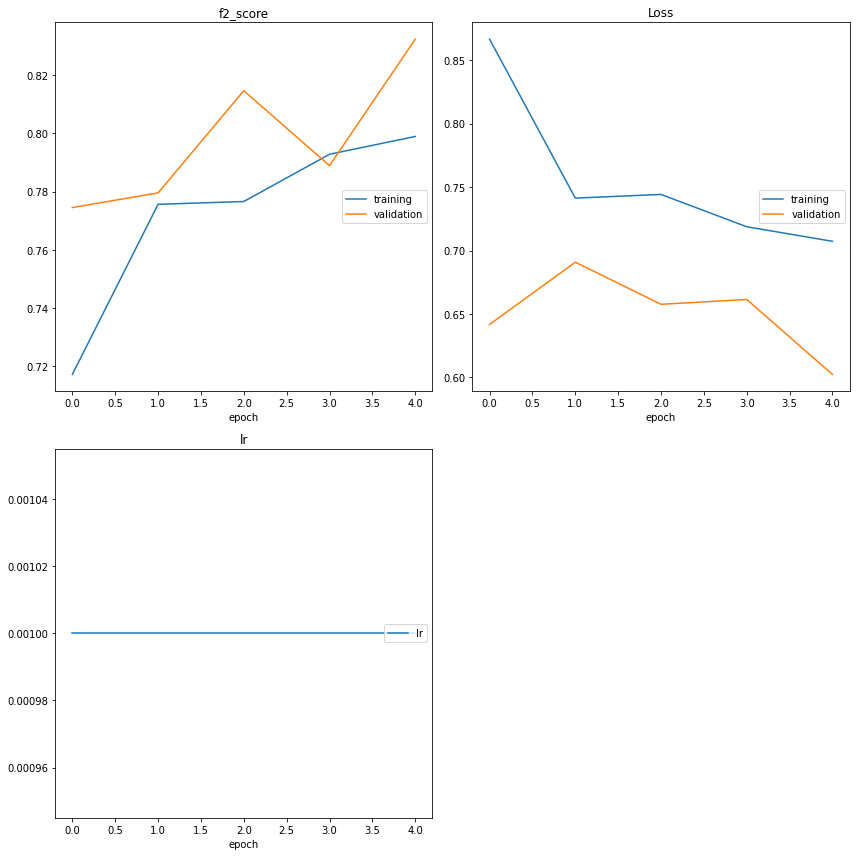

f2_score
	training         	 (min:    0.717, max:    0.799, cur:    0.799)
	validation       	 (min:    0.775, max:    0.832, cur:    0.832)
Loss
	training         	 (min:    0.707, max:    0.867, cur:    0.707)
	validation       	 (min:    0.602, max:    0.691, cur:    0.602)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
Time taken : 00:07:21


,loss,f2_score,val_loss,val_f2_score,lr
0,0.866633,0.717220,0.641732,0.774521,0.001
1,0.741322,0.775626,0.690802,0.779543,0.001
2,0.744225,0.776589,0.657624,0.814631,0.001
3,0.718755,0.792815,0.661419,0.788905,0.001
4,0.707268,0.798919,0.602332,0.832326,0.001


In [27]:
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input

resent_model = ResNet50V2(include_top=False, input_shape=INPUT_SHAPE,
                 weights='imagenet', pooling='avg')

for layer in resent_model.layers:
    layer.trainable = False

x = Flatten()(resent_model.output)
# x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(17, activation='relu')(x)

model = Model(inputs=resent_model.input, outputs=x)
# model.summary()

result_df = train_model_v2(df, model, x_col='image_name', y_col=y_cols,
                        weight_prefix='resnet50_v2_dropout', batch_size=128, epochs=25, verbose=1,
                       preprocess_input=preprocess_input)
result_df

#### ResNet model with all trainable layers

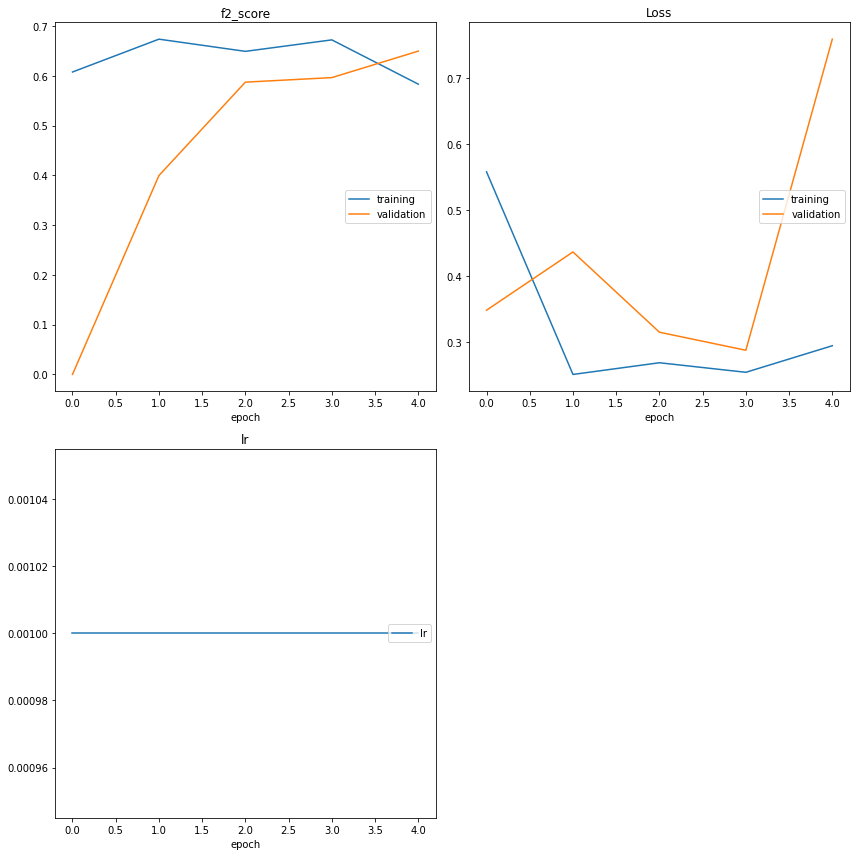

f2_score
	training         	 (min:    0.583, max:    0.674, cur:    0.583)
	validation       	 (min:    0.000, max:    0.650, cur:    0.650)
Loss
	training         	 (min:    0.251, max:    0.558, cur:    0.294)
	validation       	 (min:    0.287, max:    0.759, cur:    0.759)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
Time taken : 00:08:19


,loss,f2_score,val_loss,val_f2_score,lr
0,0.557996,0.607758,0.348035,0.000000,0.001
1,0.250571,0.673744,0.436443,0.399679,0.001
2,0.268307,0.649253,0.314630,0.587361,0.001
3,0.253811,0.672321,0.287267,0.596483,0.001
4,0.294133,0.583354,0.759333,0.649705,0.001


In [22]:
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input

resent_model = ResNet50(include_top=False, input_shape=INPUT_SHAPE,
                 weights='imagenet', pooling='avg')

for layer in resent_model.layers:
    layer.trainable = True

x = Flatten()(resent_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(17, activation='relu')(x)

model = Model(inputs=resent_model.input, outputs=x)
# model.summary()

result_df = train_model_v2(df, model, x_col='image_name', y_col=y_cols,
                        weight_prefix='resnet50_alltrain', batch_size=128, epochs=25, verbose=1,
                       preprocess_input=preprocess_input)
result_df

#### zip and load all the models

In [28]:
!zip -r weights.zip '/kaggle/working/weights'
!ls -lh weights.zip

from IPython.display import FileLink
FileLink(r'weights.zip')

updating: kaggle/working/weights/ (stored 0%)
updating: kaggle/working/weights/resnet50_weight_best.hdf5 (deflated 7%)
updating: kaggle/working/weights/resnet50_alltrain_weight_best.hdf5 (deflated 8%)
  adding: kaggle/working/weights/resnet50_v2_weight_best.hdf5 (deflated 7%)
  adding: kaggle/working/weights/resnet50_v2_dropout_weight_best.hdf5 (deflated 7%)
  adding: kaggle/working/weights/resnet50_v2_alltrain_weight_best.hdf5 (deflated 8%)


/kaggle/working/weights.zip

In [30]:
!ls -lh weights.zip

-rw-r--r-- 1 root root 426M Aug  4 19:16 weights.zip


In [35]:
for layer in resent_model.layers[-4:-1]:
    print(layer)
    